In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Toxic Comment Classification: Model Evaluation (Part 1)

This notebook evaluates and compares the performance of three different approaches for toxic comment classification:
1. Odd Layer Distillation
2. Even Layer Distillation
3. LoRA (Low-Rank Adaptation)

## Part 1: Setup and Data Loading

In this part, we'll install dependencies and load the dataset.

### 1. Install Dependencies

In [2]:
!pip install -q transformers datasets evaluate peft pandas matplotlib seaborn scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 2. Import Libraries

In [3]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 3. Define Data Loader Function

In [4]:
def load_toxic_comments_dataset(model_name_or_path="bert-base-uncased", max_length=128, batch_size=32):
    """
    Load the Jigsaw Toxic Comment Classification dataset and preprocess it.

    Args:
        model_name_or_path (str): The model name or path for the tokenizer
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for data loaders

    Returns:
        tokenizer: The tokenizer used for preprocessing
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        test_dataloader: DataLoader for test data
        num_labels: Number of labels in the dataset
    """
    print("Loading Jigsaw Toxic Comment Classification dataset...")

    # Load the Civil Comments dataset (contains toxic comments)
    from datasets import load_dataset
    dataset = load_dataset("civil_comments")

    # Extract the relevant columns (text and toxicity label)
    dataset = dataset.map(
        lambda example: {
            "text": example["text"],
            "label": 1 if example["toxicity"] > 0.5 else 0
        }
    )

    # Create a balanced dataset (50% toxic, 50% non-toxic)
    toxic_comments = dataset["train"].filter(lambda example: example["label"] == 1)
    non_toxic_comments = dataset["train"].filter(lambda example: example["label"] == 0)

    # Sample to ensure balance
    max_samples = min(len(toxic_comments), len(non_toxic_comments), 25000)  # Limit to 25k per class for efficiency
    toxic_samples = toxic_comments.select(range(max_samples))
    non_toxic_samples = non_toxic_comments.select(range(max_samples))

    # Combine and shuffle
    from datasets import concatenate_datasets
    balanced_dataset = concatenate_datasets([toxic_samples, non_toxic_samples])
    balanced_dataset = balanced_dataset.shuffle(seed=SEED)

    # Split into train, validation, and test sets (80%, 10%, 10%)
    train_val_dataset, test_dataset = balanced_dataset.train_test_split(test_size=0.1, seed=SEED).values()
    train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.11, seed=SEED).values()  # 0.11 of 90% is ~10% of total

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    # Tokenize datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    print("Tokenizing datasets...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch - remove all columns except those needed by the model
    columns_to_keep = ['input_ids', 'attention_mask', 'label']
    tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in columns_to_keep])
    tokenized_val = tokenized_val.remove_columns([col for col in tokenized_val.column_names if col not in columns_to_keep])
    tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in columns_to_keep])

    # Rename 'label' to 'labels' to match model expectations
    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')
    tokenized_test = tokenized_test.rename_column('label', 'labels')

    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")
    tokenized_test.set_format("torch")

    # Create data loaders
    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_dataloader = DataLoader(
        tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_val, batch_size=batch_size, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_test, batch_size=batch_size, collate_fn=data_collator
    )

    # Number of labels (binary classification - toxic or not)
    num_labels = 2

    return tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, tokenized_train, tokenized_val, tokenized_test

### 4. Load the Test Dataset

In [5]:
print("Loading test data...")
tokenizer, _, _, test_dataloader, _, _, _, _ = load_toxic_comments_dataset(
    model_name_or_path="bert-base-uncased",
    max_length=128,
    batch_size=32
)

Loading test data...
Loading Jigsaw Toxic Comment Classification dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Train dataset size: 40050
Validation dataset size: 4950
Test dataset size: 5000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/40050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Toxic Comment Classification: Model Evaluation (Part 2)

## Part 2: Model Loading and Evaluation Functions

In this part, we'll define functions to load the trained models and evaluate them on the test set.

In [6]:
os.chdir("/content/drive/MyDrive/NLPA7")

### 1. Model Loading Functions

In [7]:
def load_model_and_results(model_path, model_type="distillation"):
    """
    Load a trained model and its results.

    Args:
        model_path: Path to the model directory
        model_type: Type of the model ("distillation" or "lora")

    Returns:
        model: The loaded model
        tokenizer: The tokenizer
        results: Dictionary containing test results
    """
    # Load results
    with open(os.path.join(model_path, 'results.txt'), 'r') as f:
        results_text = f.read()

    # Parse results
    results = {}

    # Extract test loss
    test_loss_line = [line for line in results_text.split('\n') if 'Test loss:' in line][0]
    results['test_loss'] = float(test_loss_line.split(': ')[1])

    # Extract test accuracy
    test_acc_line = [line for line in results_text.split('\n') if 'Test accuracy:' in line][0]
    results['test_accuracy'] = float(test_acc_line.split(': ')[1])

    # Load model and tokenizer
    model_path = os.path.join(model_path, "best_model")

    if model_type == "distillation":
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
    elif model_type == "lora":
        config = PeftConfig.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
        model = PeftModel.from_pretrained(model, model_path)

    return model, tokenizer, results

### 2. Model Evaluation Function

In [8]:
def evaluate_model_on_test_set(model, tokenizer, test_dataloader):
    """
    Evaluate a model on the test set.

    Args:
        model: The model to evaluate
        tokenizer: The tokenizer
        test_dataloader: DataLoader for test data

    Returns:
        Dictionary containing evaluation metrics
    """
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    confusion = confusion_matrix(all_labels, all_predictions)

    metrics = {
        'test_loss': total_loss / len(test_dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': confusion
    }

    return metrics

### 3. Prepare for Model Evaluation

Before evaluating your models, you need to upload your trained model folders to Colab. You should have the following folders:
- odd_layer_model
- even_layer_model
- lora_model

Use the code cell below to upload your model folders. Each folder should contain a 'best_model' subdirectory and a 'results.txt' file.

In [15]:
# Create directories for the models
!mkdir -p odd_layer_model
!mkdir -p even_layer_model
!mkdir -p lora_model


!unzip -q -o "odd_layer_model.zip"
!unzip -q -o "even_layer_model.zip"
!unzip -q -o "lora_model.zip"

# Toxic Comment Classification: Model Evaluation (Part 3)

## Part 3: Model Comparison and Results Visualization

In this part, we'll evaluate all models, compare their performance, and generate visualizations and reports.

### 1. Function to Save Comparative Results

In [9]:
def save_comparative_results(results_dict, output_dir="comparison_results"):
    """
    Save comparative results of all models.

    Args:
        results_dict: Dictionary containing results for all models
        output_dir: Directory to save results
    """
    os.makedirs(output_dir, exist_ok=True)

    # Create a comparison table
    comparison_data = []
    for model_name, metrics in results_dict.items():
        row = {
            'Model Type': model_name,
            'Test Loss': metrics['test_loss'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1_score']
        }
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)

    # Save as CSV
    df.to_csv(os.path.join(output_dir, 'comparison_results.csv'), index=False)

    # Display as DataFrame
    display(df)

    # Plot metrics comparison
    plt.figure(figsize=(12, 8))

    # Metrics bar chart
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    ax = plt.subplot(2, 1, 1)
    df_plot = df.melt(id_vars=['Model Type'], value_vars=metrics_to_plot, var_name='Metric', value_name='Value')
    sns.barplot(x='Model Type', y='Value', hue='Metric', data=df_plot, ax=ax)
    plt.title('Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)

    # Loss comparison
    ax = plt.subplot(2, 1, 2)
    sns.barplot(x='Model Type', y='Test Loss', data=df, ax=ax)
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'metrics_comparison.png'))
    plt.show()

    # Plot confusion matrices
    plt.figure(figsize=(15, 5))
    for i, (model_name, metrics) in enumerate(results_dict.items()):
        plt.subplot(1, 3, i+1)
        confusion = metrics['confusion_matrix']
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non-Toxic', 'Toxic'],
                   yticklabels=['Non-Toxic', 'Toxic'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrices.png'))
    plt.show()

    # Create analysis report
    analysis_report = "# Model Comparison Analysis Report\n\n"

    analysis_report += "## Performance Comparison\n\n"

    # Find the best model for each metric
    best_model = {
        'Accuracy': df.loc[df['Accuracy'].idxmax()]['Model Type'],
        'Precision': df.loc[df['Precision'].idxmax()]['Model Type'],
        'Recall': df.loc[df['Recall'].idxmax()]['Model Type'],
        'F1 Score': df.loc[df['F1 Score'].idxmax()]['Model Type'],
        'Loss': df.loc[df['Test Loss'].idxmin()]['Model Type']
    }

    analysis_report += "## Best Performing Models\n\n"
    analysis_report += f"- **Best Accuracy**: {best_model['Accuracy']} ({df['Accuracy'].max():.4f})\n"
    analysis_report += f"- **Best Precision**: {best_model['Precision']} ({df['Precision'].max():.4f})\n"
    analysis_report += f"- **Best Recall**: {best_model['Recall']} ({df['Recall'].max():.4f})\n"
    analysis_report += f"- **Best F1 Score**: {best_model['F1 Score']} ({df['F1 Score'].max():.4f})\n"
    analysis_report += f"- **Lowest Loss**: {best_model['Loss']} ({df['Test Loss'].min():.4f})\n\n"

    analysis_report += "## Analysis of Differences\n\n"
    analysis_report += "### Odd vs Even Layer Distillation\n\n"

    odd_metrics = df[df['Model Type'] == 'Odd Layer Distillation'].iloc[0]
    even_metrics = df[df['Model Type'] == 'Even Layer Distillation'].iloc[0]

    acc_diff = odd_metrics['Accuracy'] - even_metrics['Accuracy']
    f1_diff = odd_metrics['F1 Score'] - even_metrics['F1 Score']

    if acc_diff > 0:
        analysis_report += f"Odd layer distillation outperforms even layer distillation in terms of accuracy by {abs(acc_diff):.4f}. "
    else:
        analysis_report += f"Even layer distillation outperforms odd layer distillation in terms of accuracy by {abs(acc_diff):.4f}. "

    if f1_diff > 0:
        analysis_report += f"Similarly, odd layer distillation has a higher F1 score by {abs(f1_diff):.4f}.\n\n"
    else:
        analysis_report += f"However, even layer distillation has a higher F1 score by {abs(f1_diff):.4f}.\n\n"

    analysis_report += "This suggests that "
    if acc_diff > 0:
        analysis_report += "the odd-numbered layers in BERT contain more task-relevant information for toxic comment classification. "
        analysis_report += "These layers might capture more semantic understanding needed for this task.\n\n"
    else:
        analysis_report += "the even-numbered layers in BERT contain more task-relevant information for toxic comment classification. "
        analysis_report += "These layers might capture more semantic understanding needed for this task.\n\n"

    analysis_report += "### Distillation vs LoRA\n\n"

    best_distil = odd_metrics if odd_metrics['Accuracy'] > even_metrics['Accuracy'] else even_metrics
    best_distil_name = 'Odd Layer Distillation' if odd_metrics['Accuracy'] > even_metrics['Accuracy'] else 'Even Layer Distillation'
    lora_metrics = df[df['Model Type'] == 'LoRA'].iloc[0]

    acc_diff = best_distil['Accuracy'] - lora_metrics['Accuracy']
    f1_diff = best_distil['F1 Score'] - lora_metrics['F1 Score']

    if acc_diff > 0:
        analysis_report += f"The best distillation approach ({best_distil_name}) outperforms LoRA in terms of accuracy by {abs(acc_diff):.4f}. "
    else:
        analysis_report += f"LoRA outperforms the best distillation approach ({best_distil_name}) in terms of accuracy by {abs(acc_diff):.4f}. "

    if f1_diff > 0:
        analysis_report += f"Similarly, {best_distil_name} has a higher F1 score by {abs(f1_diff):.4f}.\n\n"
    else:
        analysis_report += f"Similarly, LoRA has a higher F1 score by {abs(f1_diff):.4f}.\n\n"

    # Save analysis report
    with open(os.path.join(output_dir, 'analysis_report.md'), 'w') as f:
        f.write(analysis_report)

    # Display the analysis report
    from IPython.display import Markdown
    display(Markdown(analysis_report))

    print(f"\nResults saved to {output_dir}/")
    return df

### 2. Evaluate All Models and Compare Results

In [10]:
# Define model directories
model_dirs = {
    'Odd Layer Distillation': 'odd_layer_model',
    'Even Layer Distillation': 'even_layer_model',
    'LoRA': 'lora_model'
}

# Load models and results
results = {}

for model_name, model_dir in model_dirs.items():
    print(f"Evaluating {model_name}...")

    model_type = "lora" if model_name == "LoRA" else "distillation"
    model, tokenizer, model_results = load_model_and_results(model_dir, model_type)

    # Evaluate on test set
    metrics = evaluate_model_on_test_set(model, tokenizer, test_dataloader)

    # Store results
    results[model_name] = metrics

    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")

Evaluating Odd Layer Distillation...
  Accuracy: 0.9182
  F1 Score: 0.9198
Evaluating Even Layer Distillation...
  Accuracy: 0.9208
  F1 Score: 0.9215
Evaluating LoRA...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Accuracy: 0.9206
  F1 Score: 0.9217


### 3. Save and Visualize Comparative Results

,Model Type,Test Loss,Accuracy,Precision,Recall,F1 Score
0,Odd Layer Distillation,0.386519,0.9182,0.909302,0.930583,0.919820
1,Even Layer Distillation,0.376649,0.9208,0.920792,0.922253,0.921522
2,LoRA,0.208794,0.9206,0.916471,0.927013,0.921712


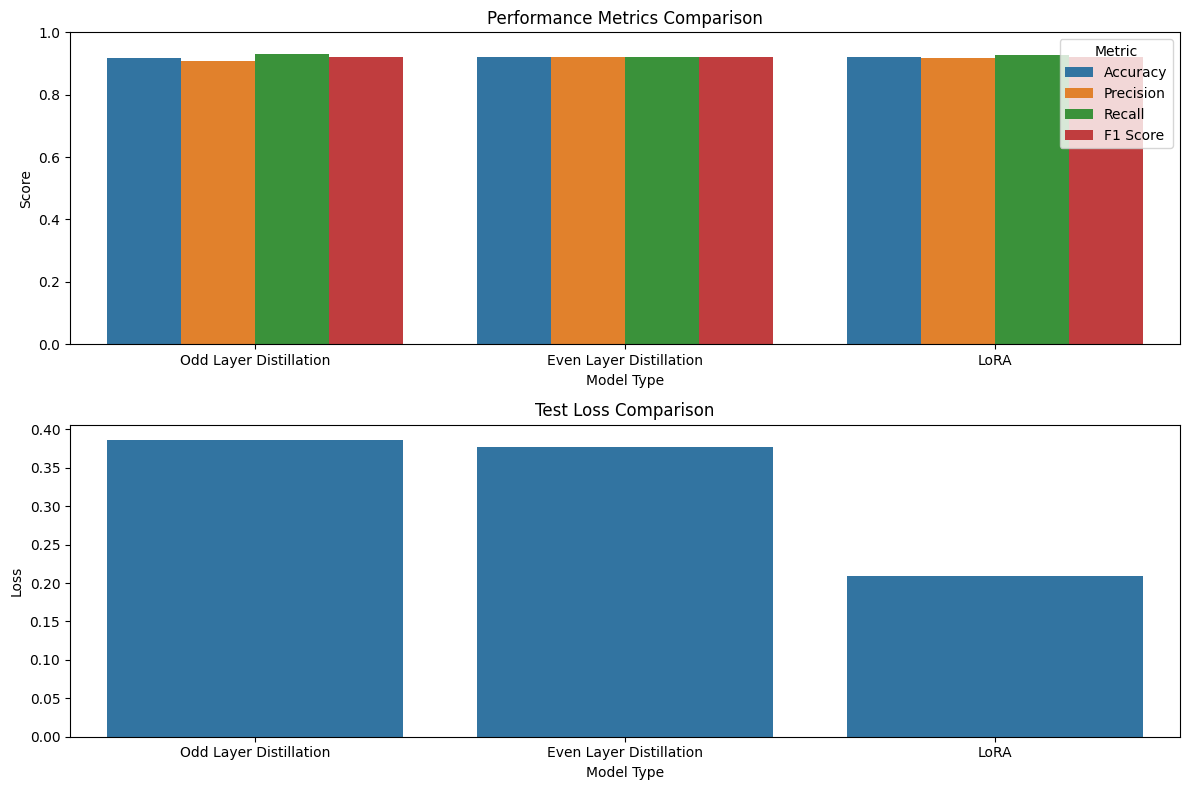

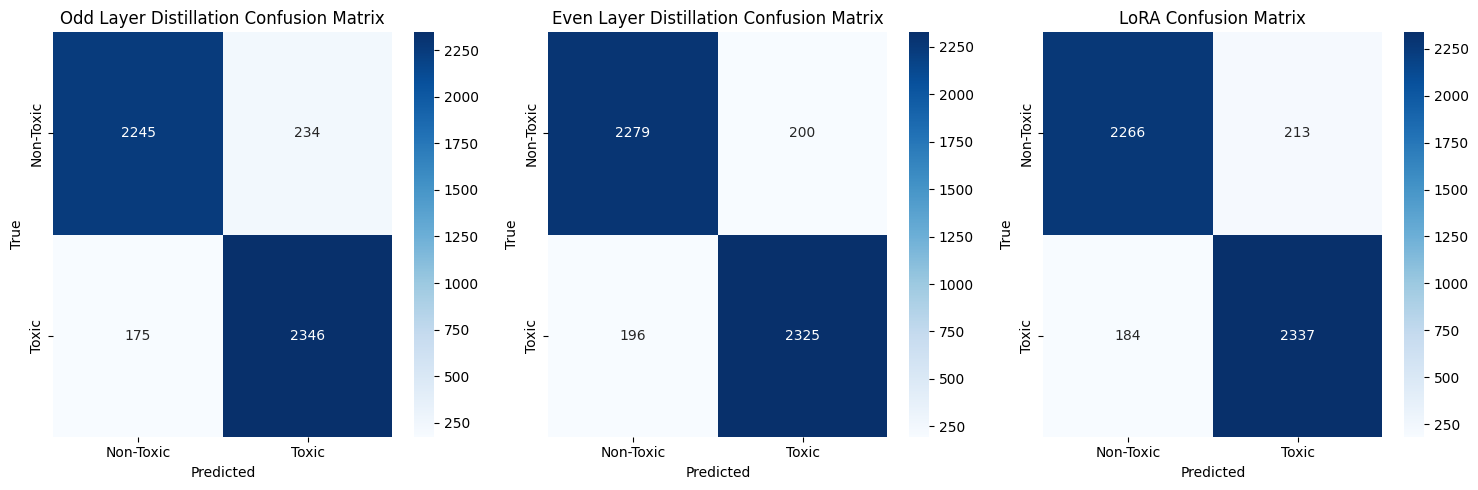

# Model Comparison Analysis Report

## Performance Comparison

## Best Performing Models

- **Best Accuracy**: Even Layer Distillation (0.9208)
- **Best Precision**: Even Layer Distillation (0.9208)
- **Best Recall**: Odd Layer Distillation (0.9306)
- **Best F1 Score**: LoRA (0.9217)
- **Lowest Loss**: LoRA (0.2088)

## Analysis of Differences

### Odd vs Even Layer Distillation

Even layer distillation outperforms odd layer distillation in terms of accuracy by 0.0026. However, even layer distillation has a higher F1 score by 0.0017.

This suggests that the even-numbered layers in BERT contain more task-relevant information for toxic comment classification. These layers might capture more semantic understanding needed for this task.

### Distillation vs LoRA

The best distillation approach (Even Layer Distillation) outperforms LoRA in terms of accuracy by 0.0002. Similarly, LoRA has a higher F1 score by 0.0002.




Results saved to comparison_results/


In [11]:
# Save comparative results
df = save_comparative_results(results)

### 4. Download Results

You can download the comparison results using the code below:

In [12]:
# Zip the results
!zip -r comparison_results.zip comparison_results/

# Download the results
from google.colab import files
files.download('comparison_results.zip')

  adding: comparison_results/ (stored 0%)
  adding: comparison_results/comparison_results.csv (deflated 36%)
  adding: comparison_results/metrics_comparison.png (deflated 21%)
  adding: comparison_results/confusion_matrices.png (deflated 15%)
  adding: comparison_results/analysis_report.md (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5. Conclusion

In this notebook, we've evaluated and compared three different approaches for toxic comment classification:
1. Odd Layer Distillation
2. Even Layer Distillation
3. LoRA (Low-Rank Adaptation)

The comparative analysis can help determine which approach is most suitable for this task, considering both performance metrics and parameter efficiency.

# Toxic Comment Classification: Model Evaluation (Part 4)

## Part 4: Sample Inference and Interactive Testing

In this part, we'll test the models on some sample comments and provide an interactive demo.

### 1. Inference Functions

In [13]:
def predict_toxicity(model, tokenizer, text, model_type="distillation"):
    """
    Predict if a comment is toxic using a model.

    Args:
        model: The trained model
        tokenizer: The tokenizer
        text: The text to classify
        model_type: Type of the model ("distillation" or "lora")

    Returns:
        prediction: Binary prediction (0=non-toxic, 1=toxic)
        probabilities: Probabilities for each class
    """
    model = model.to(device)
    model.eval()

    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    prediction = torch.argmax(logits, dim=-1).item()

    return prediction, probabilities.cpu().numpy()[0]

### 2. Load Models for Inference

In [14]:
# Define model directories
model_dirs = {
    'Odd Layer Distillation': 'odd_layer_model',
    'Even Layer Distillation': 'even_layer_model',
    'LoRA': 'lora_model'
}

# Load models for inference
inference_models = {}

for model_name, model_dir in model_dirs.items():
    print(f"Loading {model_name}...")

    model_type = "lora" if model_name == "LoRA" else "distillation"
    model, tokenizer, _ = load_model_and_results(model_dir, model_type)

    inference_models[model_name] = (model, tokenizer, model_type)

Loading Odd Layer Distillation...
Loading Even Layer Distillation...
Loading LoRA...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3. Test with Sample Comments

,Comment,Odd Layer Distillation Prediction,Odd Layer Distillation Confidence,Even Layer Distillation Prediction,Even Layer Distillation Confidence,LoRA Prediction,LoRA Confidence
0,I really enjoyed this movie and the acting was...,Non-Toxic,0.743065,Non-Toxic,0.742496,Non-Toxic,0.999103
1,This is a wonderful day and I'm happy to be here.,Non-Toxic,0.739768,Non-Toxic,0.738704,Non-Toxic,0.999066
2,You are such an idiot and I hate you so much!,Toxic,0.729309,Toxic,0.744057,Toxic,0.998829
3,"I can't believe how stupid this article is, wh...",Toxic,0.728700,Toxic,0.751419,Toxic,0.997938
4,The service at this restaurant was absolutely ...,Non-Toxic,0.731390,Non-Toxic,0.732319,Non-Toxic,0.998507
5,This product has some issues that need to be f...,Non-Toxic,0.756923,Non-Toxic,0.751538,Non-Toxic,0.998723


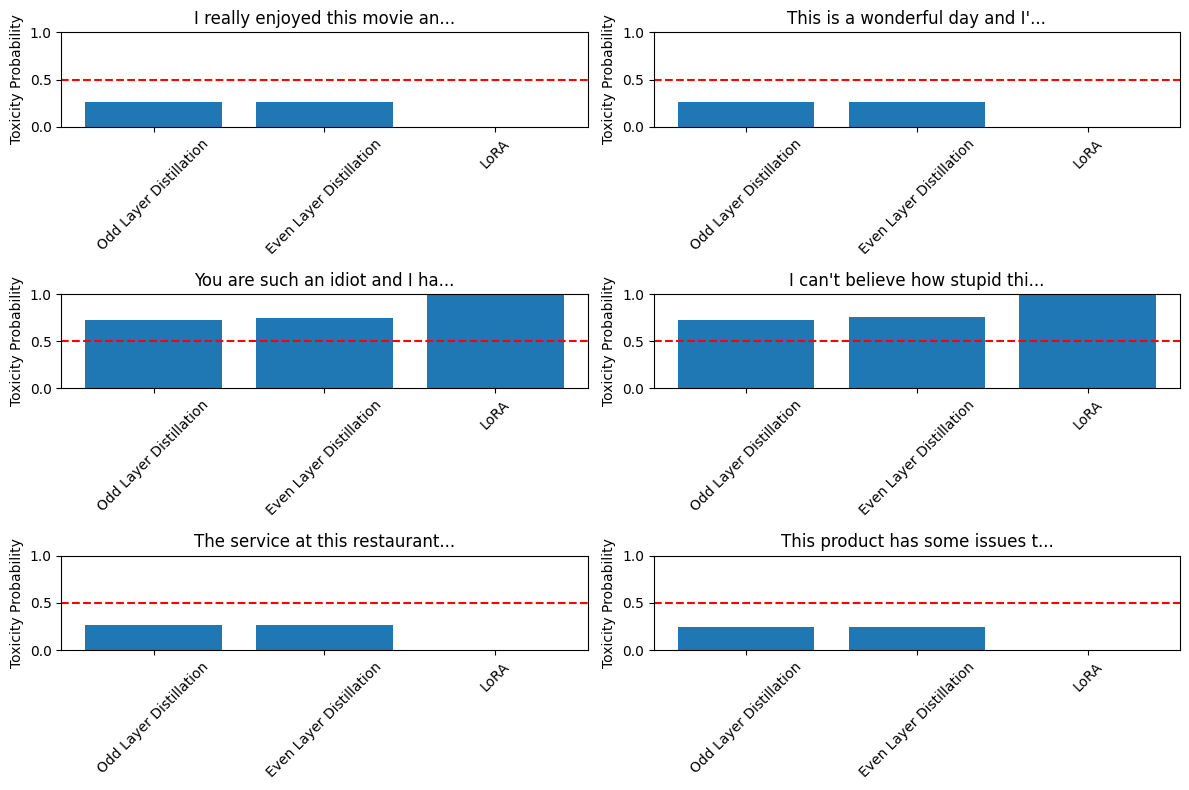

In [15]:
# Sample comments to test
sample_comments = [
    "I really enjoyed this movie and the acting was fantastic!",
    "This is a wonderful day and I'm happy to be here.",
    "You are such an idiot and I hate you so much!",
    "I can't believe how stupid this article is, what a waste of time.",
    "The service at this restaurant was absolutely terrible.",
    "This product has some issues that need to be fixed."
]

# Test all models on sample comments
results = []

for comment in sample_comments:
    row = {'Comment': comment}

    for model_name, (model, tokenizer, model_type) in inference_models.items():
        prediction, probabilities = predict_toxicity(model, tokenizer, comment, model_type)
        toxic_prob = probabilities[1]  # Probability of being toxic
        row[f"{model_name} Prediction"] = "Toxic" if prediction == 1 else "Non-Toxic"
        row[f"{model_name} Confidence"] = toxic_prob if prediction == 1 else 1 - toxic_prob

    results.append(row)

# Display results as a table
results_df = pd.DataFrame(results)
display(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
model_names = list(inference_models.keys())

for i, comment in enumerate(sample_comments):
    plt.subplot(3, 2, i+1)

    toxic_probs = []
    for model_name, (model, tokenizer, model_type) in inference_models.items():
        _, probabilities = predict_toxicity(model, tokenizer, comment, model_type)
        toxic_probs.append(probabilities[1])

    plt.bar(model_names, toxic_probs)
    plt.title(f"{comment[:30]}..." if len(comment) > 30 else comment)
    plt.ylabel("Toxicity Probability")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.axhline(y=0.5, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('sample_inference_results.png')
plt.show()

### 4. Interactive Demo

In [19]:
from IPython.display import clear_output

def interactive_demo():
    print("Toxic Comment Classification Interactive Demo")
    print("Enter a comment to classify or 'quit' to exit.")

    while True:
        user_input = input("\nEnter a comment: ")
        if user_input.lower() == 'quit':
            break

        results = []
        for model_name, (model, tokenizer, model_type) in inference_models.items():
          prediction, probabilities = predict_toxicity(model, tokenizer, user_input, model_type)
          toxic_prob = probabilities[1]  # Probability of being toxic
          non_toxic_prob = probabilities[0]  # Probability of being non-toxic

          result = f"{model_name}: {'Toxic' if prediction == 1 else 'Non-Toxic'} "
          confidence = toxic_prob if prediction == 1 else non_toxic_prob
          result += f"(Confidence: {confidence:.4f})"
          results.append(result)


        clear_output()
        print("Toxic Comment Classification Interactive Demo")
        print("Enter a comment to classify or 'quit' to exit.")
        print(f"\nYour comment: {user_input}")
        print("\nResults:")
        for result in results:
            print(f"- {result}")

    print("Demo ended. Thank you!")

In [20]:
# Run the interactive demo
interactive_demo()

Toxic Comment Classification Interactive Demo
Enter a comment to classify or 'quit' to exit.

Your comment: i swear to god I am done with this relationship. You either listen to me or youll be on your own

Results:
- Odd Layer Distillation: Non-Toxic (Confidence: 0.7416)
- Even Layer Distillation: Non-Toxic (Confidence: 0.7509)
- LoRA: Toxic (Confidence: 0.8318)

Enter a comment: quit
Demo ended. Thank you!
